In [1]:
%matplotlib inline

In [2]:
from scipy import io, signal
from kid_readout.measurement import core
from kid_readout.measurement.io import npy
from kid_readout.measurement import plot_basic
from kid_readout.analysis.resonator import plot_resonator
from kid_readout.roach import calculate, demodulator

# Wideband filter coefficients

In [3]:
coeffs = io.loadmat('/data/readout/archive/coeffs_8_tap_hamming_11.mat')['coeffs'][0]

In [4]:
coeffs.shape

(16384,)

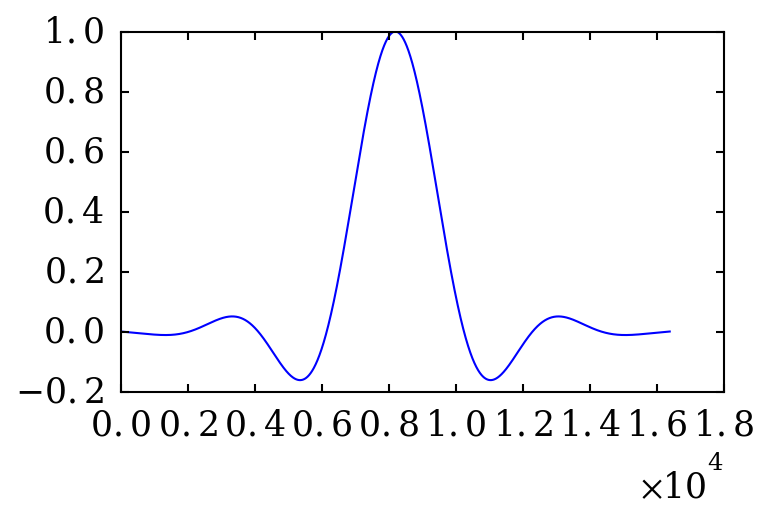

In [5]:
fig, ax = plt.subplots()
ax.plot(coeffs)

In [6]:
np.log2(coeffs.size)

14.0

In [7]:
pad = 2**6
c = np.fft.fft(coeffs, n=coeffs.size * pad)

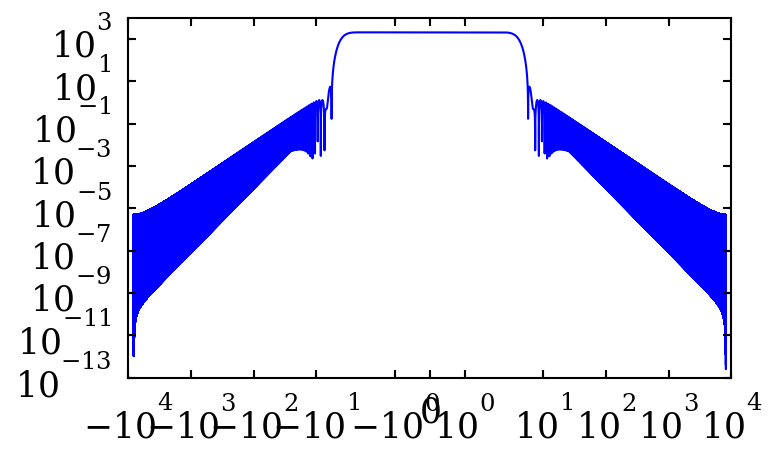

In [8]:
x = np.arange(-c.size // 2, c.size // 2)
fig, ax = plt.subplots()
ax.set_xscale('symlog')
ax.set_yscale('log')
ax.plot(x / pad, np.abs(np.fft.fftshift(c)))

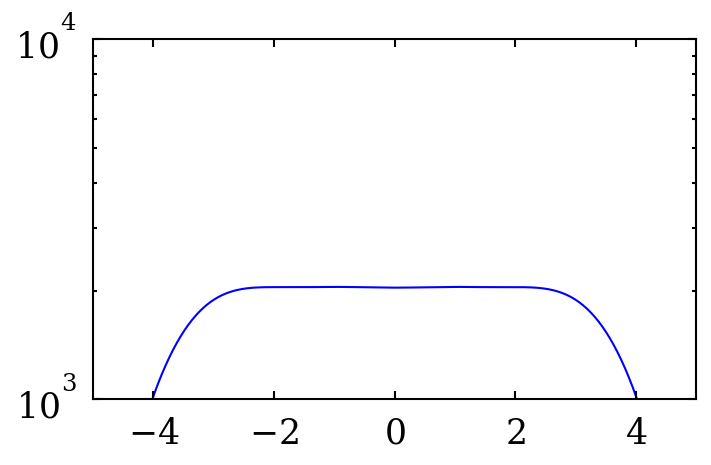

In [9]:
x = np.arange(-c.size // 2, c.size // 2)
fig, ax = plt.subplots()
ax.set_xlim(-5, 5)
ax.set_ylim(1e3, 1e4)
ax.set_xscale('linear')
ax.set_yscale('log')
ax.plot(x / pad, np.abs(np.fft.fftshift(c)))
#ax.axvline(3, color='gray')

In [10]:
C = np.abs(np.fft.fftshift(c)) / np.abs(c).max()

# Wideband data

In [11]:
npd = npy.NumpyDirectory('/data/detectors/2016-12-07_184528_sweep_stream_on_off_wideband/')

In [12]:
all_sss = [npd.read(name) for name in npd.node_names() if name.startswith('SingleSweepStream')]
all_snap = [npd.read(name) for name in npd.node_names() if name.startswith('ADCSnap')]

In [13]:
num_channels = 1
sss_dict = {}
for channel in range(num_channels):
    sss_dict[channel] = [sss for sss in all_sss if sss.state.lo_index == channel]

In [14]:
bin(all_sss[0].stream.roach_state.fft_shift_register)

'0b11111111111111111000'

In [15]:
all_sss[0].sweep.streams[0].roach_state.waveform_normalization

7.62939453125e-06

In [16]:
all_sss[0].stream.roach_state.num_filterbank_channels

2048

In [17]:
all_sss[0].stream.roach_state

StateDict({u'boffile': u'iq2xpfb11mcr11_2016_Jun_30_1215.bof', u'modulation_output': 0, u'modulation_rate': 0, u'fft_shift_register': 1048568, u'num_tone_samples': 262144, u'bank': 255, u'num_filterbank_channels': 2048, u'loopback': False, u'lo_frequency': 2243800000.0, u'adc_sample_rate': 512000000.0, u'waveform_normalization': 7.62939453125e-06, u'hardware_delay_samples': 0.0, u'num_tones': 2, u'debug_register': 0, u'reference_sequence_number': -1, u'dac_attenuation': 20.0, u'heterodyne': True})

# Demodulator

In [18]:
demod = demodulator.Demodulator(nfft=all_sss[0].stream.roach_state.num_filterbank_channels, num_taps=8,
                                window=signal.hamming, hardware_delay_samples=0)
#demod._window_frequency /= 2

def demodulate(stream):
    wn = stream.roach_state.waveform_normalization
    d = demod.demodulate(data=stream.s21_raw,
                         tone_bin=stream.tone_bin[stream.tone_index],
                         tone_num_samples=stream.roach_state.num_tone_samples,
                         tone_phase = stream.tone_phase[stream.tone_index],
                         fft_bin=stream.filterbank_bin,
                         nchan=None,
                         seq_nos=None)
    return wn * d

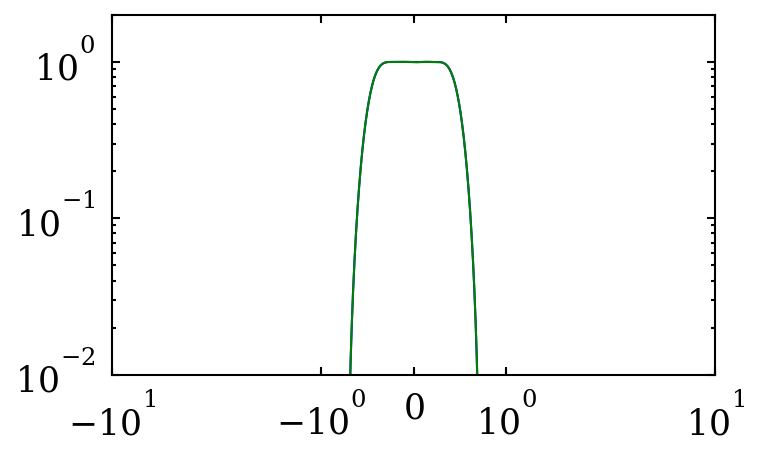

In [19]:
fig, ax = plt.subplots()
ax.set_xscale('symlog')
ax.set_yscale('log')
ax.set_xlim(-1e1, 1e1)
ax.set_ylim(1e-2, 2)
ax.plot(demod._window_frequency, demod._window_response)
ax.plot(x / (pad * demod.num_taps), C)

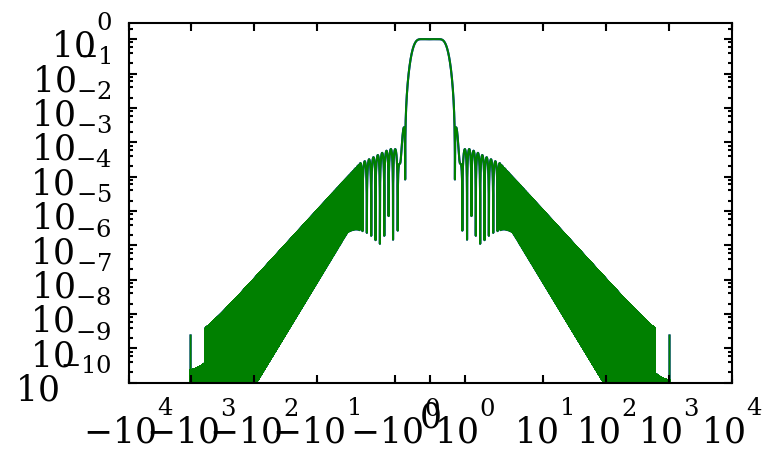

In [20]:
fig, ax = plt.subplots()
ax.set_xscale('symlog')
ax.set_yscale('log')
#ax.set_xlim(-1e1, 1e1)
ax.set_ylim(1e-10, 3)
ax.plot(demod._window_frequency, demod._window_response)
ax.plot(x / (pad * demod.num_taps), C)

# Raw data

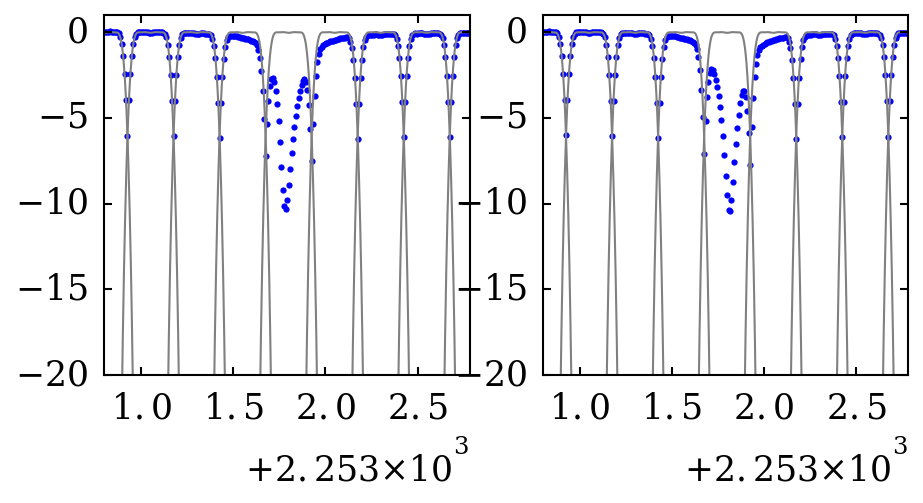

In [21]:
f_scale = 1e-6

fig, axes = plt.subplots(1, 2, figsize=(4, 2))
for sss, ax in zip(all_sss, axes.flatten()):
    f_lo = sss.stream.roach_state.lo_frequency
    f_filterbank = sss.stream.roach_state.adc_sample_rate
    ax.set_ylim(-20, 1)
    ax.set_xlim(f_scale * sss.sweep.streams[0].frequency, f_scale * sss.sweep.streams[-1].frequency)
    for stream in sss.sweep.streams:
        ax.plot(f_scale * stream.frequency,
                20 * np.log10(np.mean(np.abs(stream.s21_raw)) /
                              np.mean(np.abs(sss.sweep.streams[0].s21_raw)).max()),
                '.b')
    for filterbank_bin in np.unique([stream.filterbank_bin for stream in sss.sweep.streams]):
        f_filterbank = (sss.stream.roach_state.adc_sample_rate * filterbank_bin /
                        sss.stream.roach_state.num_filterbank_channels)
        ax.plot(f_scale * (f_lo + f_filterbank + sss.stream.stream_sample_rate * demod._window_frequency),
                20 * np.log10(demod._window_response),
                '-', color='gray')

# Demodulated data

To do: modify this to actually deep copy the objects somehow

In [22]:
all_sssd = []
for sss in all_sss:
    sssd = sss.__class__(sweep=sss.sweep.__class__(streams=core.MeasurementList([ss.as_class(ss.__class__) for ss in sss.sweep.streams])),
                         stream=sss.stream.as_class(sss.stream.__class__),
                         state=sss.state)
    all_sssd.append(sssd)
    for stream in sssd.sweep.streams:
        stream.s21_raw = demodulate(stream)
    sssd.stream.s21_raw = demodulate(sssd.stream)

In [23]:
sssd.stream.tone_offset_frequency()

array([  0.2890625,  40.2890625])

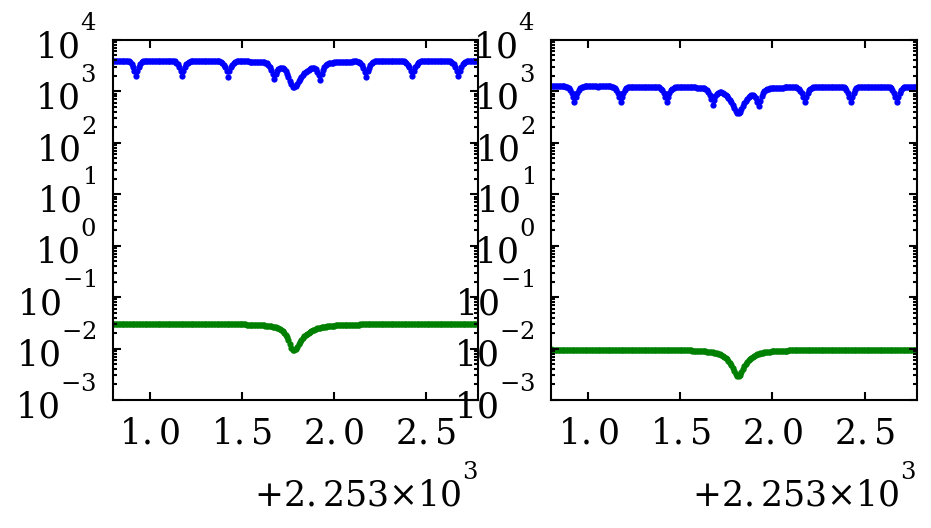

In [24]:
f_scale = 1e-6

fig, axes = plt.subplots(1, 2, figsize=(4, 2))
for sssu, sssd, ax in zip(all_sss, all_sssd, axes.flatten()):
    ax.set_yscale('log')
    ax.set_xlim(f_scale * sssd.sweep.streams[0].frequency, f_scale * sssd.sweep.streams[-1].frequency)
    for ustream, dstream in zip(sssu.sweep.streams, sssd.sweep.streams):
        ax.plot(f_scale * ustream.frequency, np.mean(np.abs(ustream.s21_raw)), '.b')
        ax.plot(f_scale * dstream.frequency, np.abs(np.mean(dstream.s21_raw)), '.g')

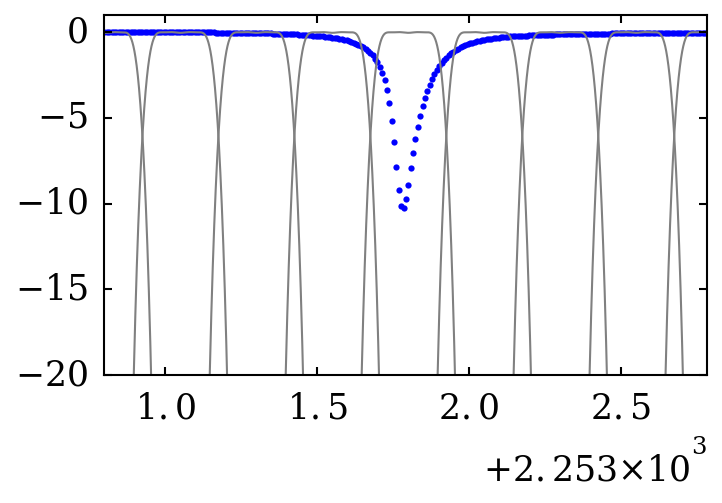

In [25]:
sssd = all_sssd[0]
f_lo = sssd.stream.roach_state.lo_frequency
f_filterbank = sssd.stream.roach_state.adc_sample_rate
offset_dB = 30.4

f_scale = 1e-6
fig, ax = plt.subplots()
ax.set_ylim(-20, 1)
ax.set_xlim(f_scale * sssd.sweep.streams[0].frequency, f_scale * sssd.sweep.streams[-1].frequency)

for stream in sssd.sweep.streams:
    ax.plot(f_scale * stream.frequency, offset_dB + 20 * np.log10(np.abs(np.mean(stream.s21_raw))), '.b')
for filterbank_bin in np.unique([stream.filterbank_bin for stream in sssd.sweep.streams]):
    f_filterbank = (sssd.stream.roach_state.adc_sample_rate * filterbank_bin /
                    sssd.stream.roach_state.num_filterbank_channels)
    ax.plot(f_scale * (f_lo + f_filterbank + sssd.stream.stream_sample_rate * demod._window_frequency),
            20 * np.log10(demod._window_response),
            '-', color='gray')

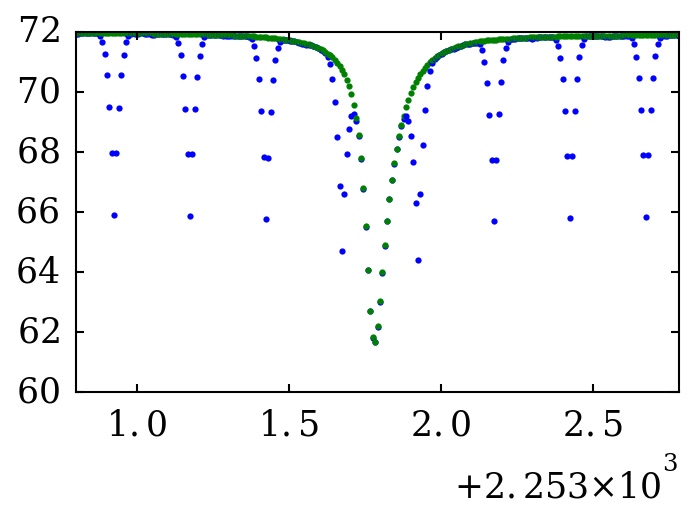

In [26]:
sss = all_sss[0]
f_nyquist = sss.stream.stream_sample_rate / 2
f_lo = sss.stream.roach_state.lo_frequency
f_filterbank = sss.stream.roach_state.adc_sample_rate
offset_dB = 30.4

f_scale = 1e-6
fig, ax = plt.subplots()
#ax.set_ylim(-50, -29)
ax.set_xlim(f_scale * sss.sweep.streams[0].frequency, f_scale * sss.sweep.streams[-1].frequency)

for stream in sss.sweep.streams:
    ax.plot(f_scale * stream.frequency,
            20 * np.log10(np.mean(np.abs(stream.s21_raw))),
            '.b')
    ax.plot(f_scale * stream.frequency,
            20 * np.log10(np.mean(np.abs(stream.s21_raw)) * 
                          demod.compute_pfb_response(stream.tone_offset_frequency()[stream.tone_index])),
            '.g')

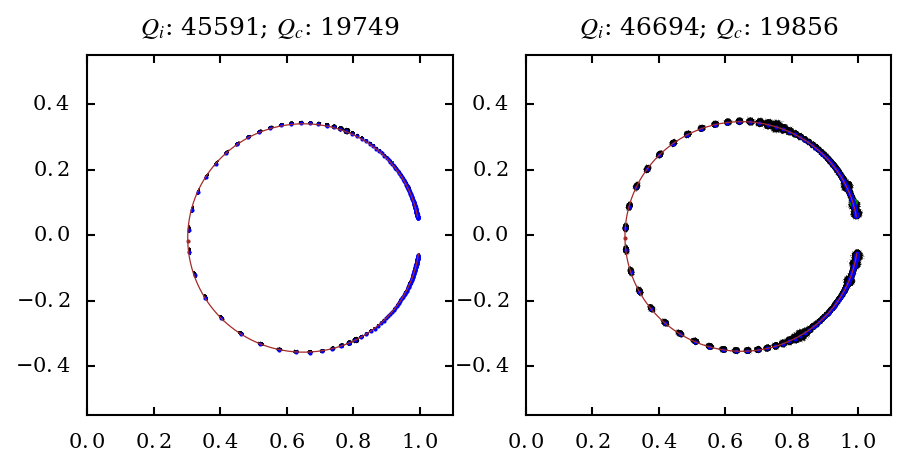

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(4, 2))
for sssd, ax in zip(all_sssd, axes.flatten()):
    ax.set_xlim(0, 1.1)
    ax.set_ylim(-0.55, 0.55)
    plot_basic.sss_complex_plane(sssd, ax, normalize=True)
    ax.set_title("$Q_i$: {:.0f}; $Q_c$: {:.0f}".format(sssd.resonator.Q_i, sssd.resonator.Q_e_real), fontsize=6)
    ax.tick_params(labelsize=5)

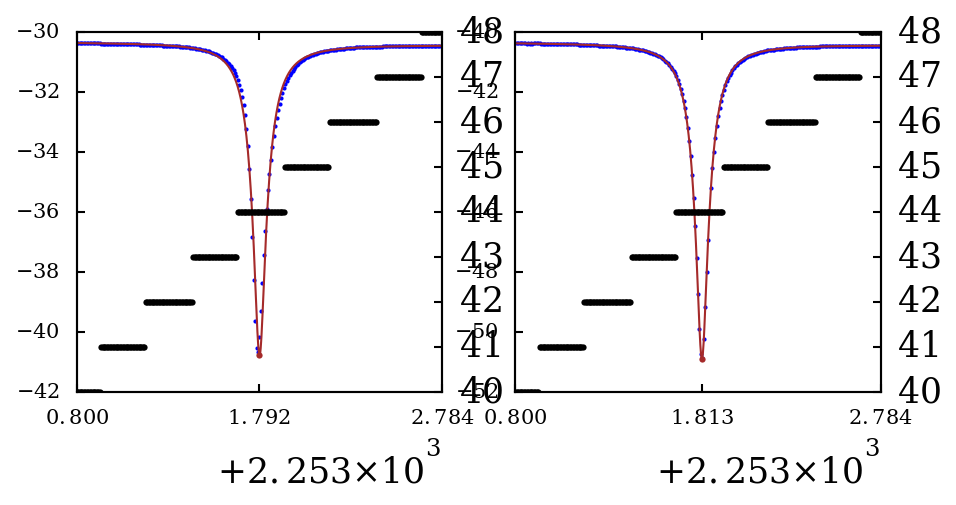

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(4, 2))
for sssd, ax in zip(all_sssd, axes.flatten()):
    plot_resonator.amplitude(ax, sssd.resonator, normalize=False)
    pfb_ax = ax.twinx()
    pfb_ax.plot(1e-6 * sssd.sweep.frequency, [stream.filterbank_bin for stream in sssd.sweep.streams], '.k')
    ax.tick_params(labelsize=3)
    pfb_ax.tick_params(labelsize=3)

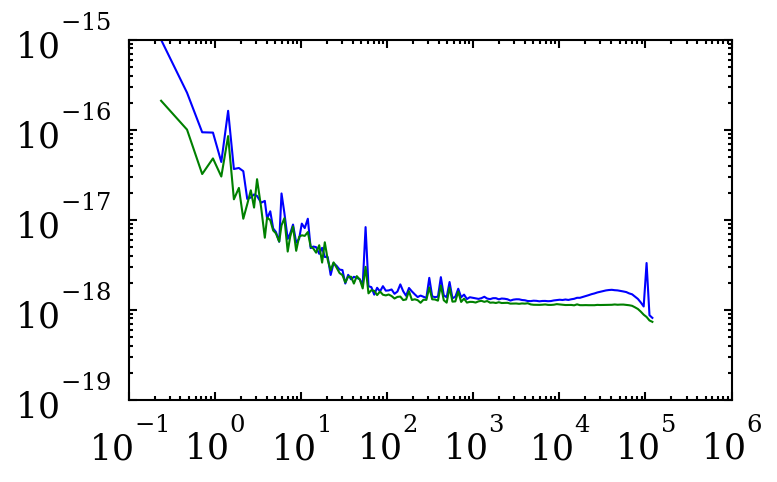

In [34]:
sssd = all_sssd[0]

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(sssd.S_frequency,
        sssd.S_xx,
        '-b')
ax.plot(sssd.S_frequency,
        sssd.S_yy,
        '-g')

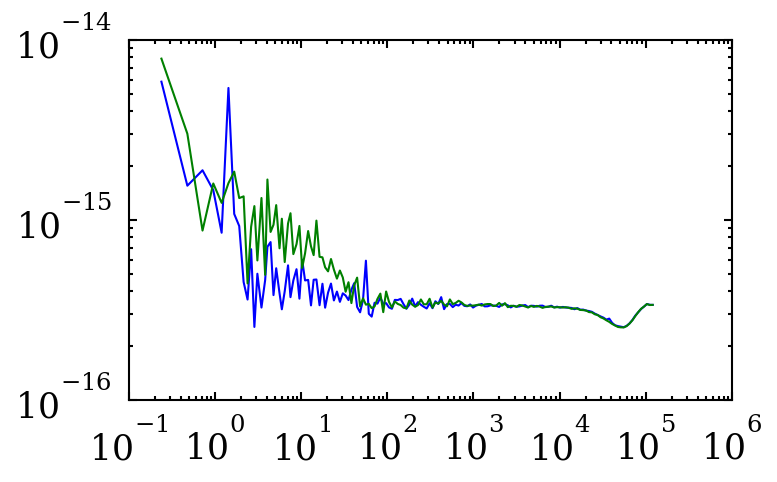

In [33]:
sssd = all_sssd[1]

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(sssd.S_frequency,
        sssd.S_xx,
        '-b')
ax.plot(sssd.S_frequency,
        sssd.S_yy,
        '-g')